# АНСАМБЛИ МОДЕЛЕЙ

Загружаем библиотеки

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tqdm
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# игнорировать предупреждения
import warnings
warnings.filterwarnings("ignore")


#### Предобработка

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#### Модели

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

#### Метрики

In [4]:
from sklearn.metrics import auc, roc_curve


# Часть 1. Бэггинг

## Описание задачи

Используем данные страхового подразделения BNP Paribas

Решается задача классификации страховых случаев:
    1. Случаи, требующие дополнительных документов для подтвердения (0)
    2. Случаи, которые можно подтверждать автоматически на основе имеющейся информации (1)

## Загрузка данных

In [5]:
data = pd.read_csv('Paribas.csv')
data

,ID,target,v1,v2,v3,v4,v5,v6,v7,v8,...,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
0,3,1,1.335739,8.727474,C,3.921026,7.915266,2.599278,3.176895,0.012941,...,8.000000,1.989780,0.035754,AU,1.804126,3.113719,2.024285,0,0.636365,2.857144
1,4,1,NaN,NaN,C,NaN,9.191265,NaN,NaN,2.301630,...,NaN,NaN,0.598896,AF,NaN,NaN,1.957825,0,NaN,NaN
2,5,1,0.943877,5.310079,C,4.410969,5.326159,3.979592,3.928571,0.019645,...,9.333333,2.477596,0.013452,AE,1.773709,3.922193,1.120468,2,0.883118,1.176472
3,6,1,0.797415,8.304757,C,4.225930,11.627438,2.097700,1.987549,0.171947,...,7.018256,1.812795,0.002267,CJ,1.415230,2.954381,1.990847,1,1.677108,1.034483
4,8,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Z,NaN,NaN,NaN,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114316,228708,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,AL,NaN,NaN,NaN,0,NaN,NaN
114317,228710,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,E,NaN,NaN,NaN,1,NaN,NaN
114318,228711,1,NaN,NaN,C,NaN,10.069277,NaN,NaN,0.323324,...,NaN,NaN,0.156764,Q,NaN,NaN,2.417606,2,NaN,NaN
114319,228712,1,NaN,NaN,C,NaN,10.106144,NaN,NaN,0.309226,...,NaN,NaN,0.490658,BW,NaN,NaN,3.526650,0,NaN,NaN


In [6]:
data.shape

(114321, 133)

#### Уменьшим размер данных для ускорения обучения, возмем случайную подвыборку 20% данных со стратификацией

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

random_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=777)

for train_index, test_index in random_splitter.split(data, data.target):
    data = data.iloc[test_index]

In [8]:
data.shape

(22865, 133)

In [10]:
X = data.drop(columns=['target'], axis=1)
y = data['target']


## Первичный анализ

Размер датасета

In [11]:
X.shape

(22865, 132)

Распределение значений таргета (event rate)

In [12]:
y.value_counts() / len(data)

1    0.761207
0    0.238793
Name: target, dtype: float64

## Предобработка данных

Находим категориальные признаки

Чтобы в разы не увеличивать число признаков при построении dummy, будем использовать категориальные признаки с < 30 уникальных значений

In [13]:
cat_feat = list(X.dtypes[X.dtypes == object].index)
print("cat_feat",len(cat_feat))
#закодируем пропущенные значений строкой, факт пропущенного значения тоже может нести в себе информацию
X[cat_feat] = X[cat_feat].fillna('nan')
#Мы планируем использовать эти данные в будущем для демикодирования

#отфильтруем непрерывные признаки
num_feat = [f for f in X if f not in (cat_feat + ['ID'])]
print("num_feat",len(num_feat))

cat_nunique = X[cat_feat].nunique()
print(cat_nunique)
cat_feat = list(cat_nunique[cat_nunique < 30].index)  # учитываем переменные только со значением менее 30

cat_feat 19
num_feat 112
v3         4
v22     8177
v24        5
v30        8
v31        4
v47        9
v52       12
v56       97
v66        3
v71        5
v74        3
v75        4
v79       17
v91        7
v107       7
v110       3
v112      23
v113      35
v125      89
dtype: int64


In [14]:
X_median = X[num_feat].median()

In [15]:
dummy_X = pd.get_dummies(X[cat_feat], columns=cat_feat)

In [16]:
X_new = pd.concat([X[num_feat].fillna(X_median),
                     X[num_feat + cat_feat].isnull().astype(np.int8).add_suffix('_NaN'),
                     dummy_X], axis=1)

In [17]:
scaler = StandardScaler()
scaler.fit(X_new)

StandardScaler()

In [18]:
X_norm = scaler.transform(X_new)
X_norm = pd.DataFrame(X_norm, columns = X_new.columns)
X_norm

,v1,v2,v4,v5,v6,v7,v8,v9,v10,v11,...,v112_N,v112_O,v112_P,v112_Q,v112_R,v112_S,v112_T,v112_U,v112_V,v112_nan
0,-0.116268,-0.111927,0.039254,-0.024957,-0.029752,-0.040652,-0.296161,0.011390,1.636298,0.049095,...,-0.289311,-0.180959,-0.201012,-0.145183,-0.19323,-0.085776,-0.190535,-0.207403,-0.129303,-0.06356
1,-0.116268,-0.111927,0.039254,-0.024957,-0.029752,-0.040652,-0.296161,0.011390,-0.412292,0.049095,...,-0.289311,-0.180959,-0.201012,-0.145183,-0.19323,-0.085776,-0.190535,-0.207403,-0.129303,-0.06356
2,2.345362,0.035089,1.074839,-1.799855,-2.047425,-0.835527,-0.469607,-1.055173,0.322698,2.335419,...,-0.289311,-0.180959,-0.201012,-0.145183,-0.19323,-0.085776,-0.190535,-0.207403,-0.129303,-0.06356
3,-0.116268,-0.111927,0.039254,-0.024957,-0.029752,-0.040652,-0.296161,0.011390,2.699688,0.049095,...,-0.289311,-0.180959,-0.201012,-0.145183,-0.19323,-0.085776,-0.190535,-0.207403,-0.129303,-0.06356
4,2.807361,-0.855821,-2.179987,0.470938,-0.303051,-1.708449,0.770806,-0.141242,-0.412292,-0.093118,...,-0.289311,-0.180959,-0.201012,-0.145183,-0.19323,-0.085776,-0.190535,-0.207403,-0.129303,-0.06356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22860,-0.119412,-1.120544,0.391201,0.648138,0.862795,-0.233674,1.278543,0.336872,-0.803244,0.023753,...,-0.289311,-0.180959,-0.201012,-0.145183,-0.19323,-0.085776,-0.190535,-0.207403,-0.129303,-0.06356
22861,-0.116268,-0.111927,0.039254,-0.024957,-0.029752,-0.040652,-0.296161,0.011390,-0.615587,0.049095,...,-0.289311,-0.180959,-0.201012,-0.145183,-0.19323,-0.085776,-0.190535,-0.207403,-0.129303,-0.06356
22862,-0.116268,-0.111927,0.039254,-0.024957,-0.029752,-0.040652,-0.296161,0.011390,-0.803244,0.049095,...,-0.289311,-0.180959,-0.201012,-0.145183,-0.19323,-0.085776,-0.190535,-0.207403,-0.129303,-0.06356
22863,-0.116268,-0.111927,0.039254,-0.024957,-0.029752,-0.040652,-0.296161,0.011390,-0.412292,0.049095,...,-0.289311,-0.180959,-0.201012,-0.145183,-0.19323,-0.085776,-0.190535,-0.207403,-0.129303,-0.06356


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=42)

In [20]:
X_train.shape

(18292, 353)

#### Функция для подсчета  ROC AUC и постройки графика

In [21]:
def calc_auc(y, y_pred, plot_label='', prin=True):
    fpr, tpr, _ = roc_curve(y, y_pred)
    auc_val = auc(fpr, tpr)
    if prin:
        print('ROC AUC: {0:.4f}'.format(auc_val))
    if plot_label:
        plt.plot(fpr, tpr, label=plot_label)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
    return auc_val

### Логистическая регрессия

In [22]:
clf_lr = LogisticRegression(penalty='l2', C=0.01, random_state=42)

clf_lr.fit(X_train, y_train)

LogisticRegression(C=0.01, random_state=42)

Train:
ROC AUC: 0.7356
Test:
ROC AUC: 0.7225


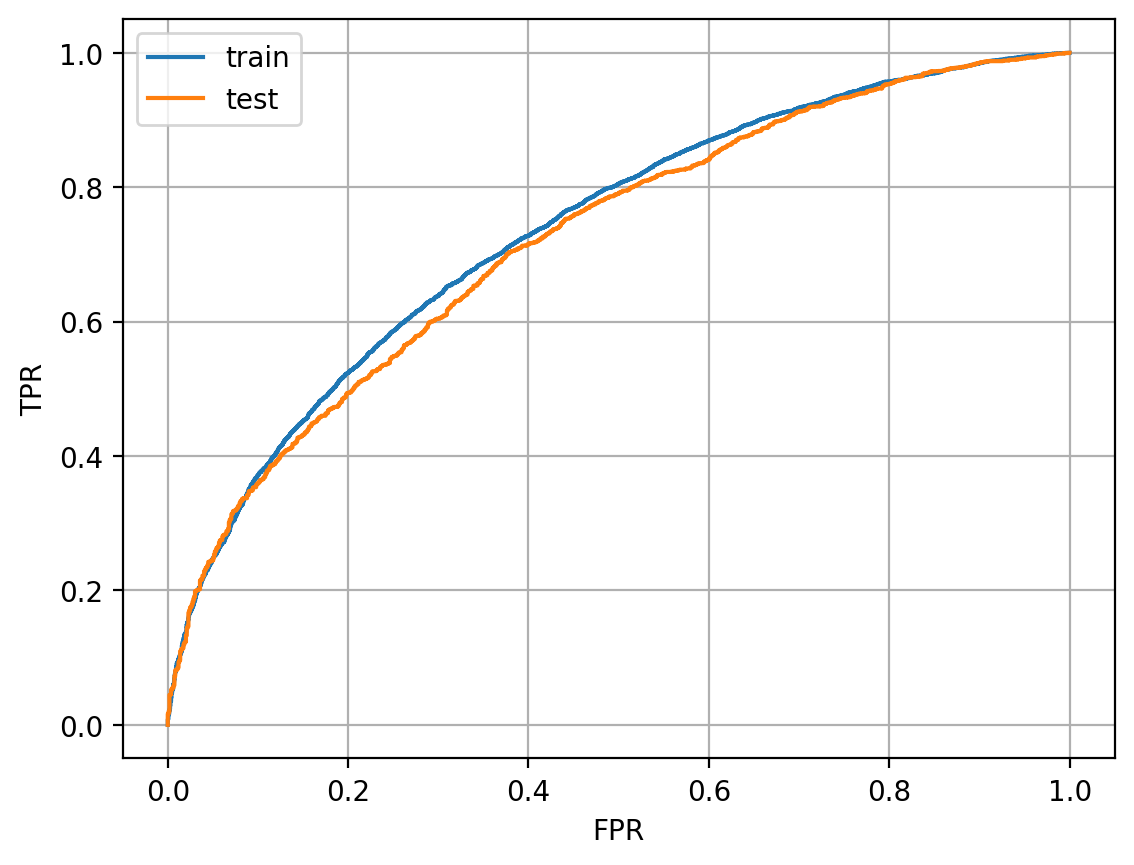

In [23]:
y_pred_lin_test = clf_lr.predict_proba(X_test)[:, 1]
y_pred_lin_train = clf_lr.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_lin_train, 'train')
print('Test:')
calc_auc(y_test, y_pred_lin_test, 'test')
plt.grid()

plt.legend();

### Решающие деревья

1. Неустойчивы к входным данным
2. Склонны к переобучению
3. Быстро обучаются

=> хороший выбор для построения композиций


Обучаем решающее дерево

Ограничим глубину и минимальное кол-во объектов в листе для уменьшения переобучения

In [24]:
clf_tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, random_state=42)
clf_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, random_state=42)

Предсказываем вероятность класса 1 и считаем ROC AUC

Train:
ROC AUC: 0.7342
Test:
ROC AUC: 0.7125


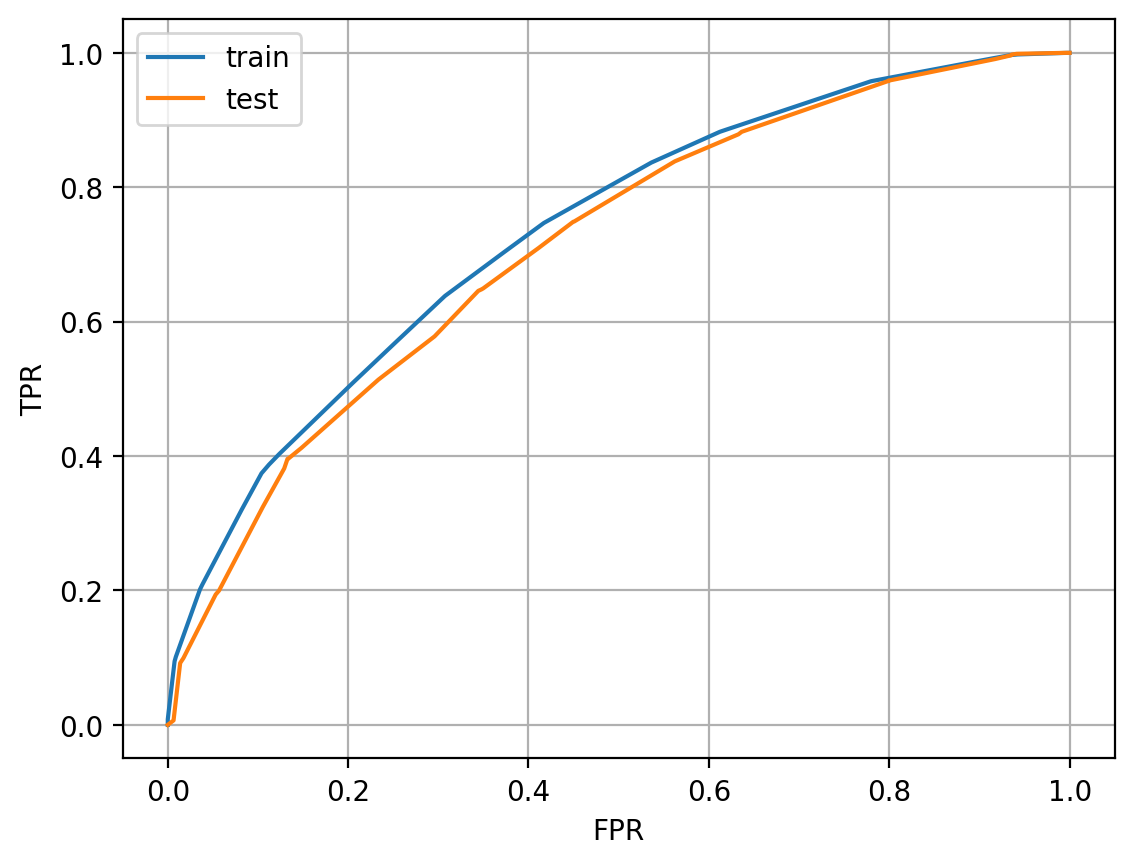

In [25]:
y_pred_train_tr = clf_tree.predict_proba(X_train)[:, 1]
y_pred_test_tr = clf_tree.predict_proba(X_test)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_train_tr, 'train')
print('Test:')
calc_auc(y_test, y_pred_test_tr, 'test')
plt.grid()
plt.legend();

### Классификатор с голосованием

In [26]:
from sklearn.ensemble import VotingClassifier

In [27]:
voting_clf = VotingClassifier(
    estimators=[('DTree', clf_tree), ('LogR', clf_lr)], voting='soft', n_jobs=-1) 

In [28]:
%%time
voting_clf.fit(X_train, y_train)

CPU times: total: 78.1 ms
Wall time: 2.99 s


VotingClassifier(estimators=[('DTree',
                              DecisionTreeClassifier(max_depth=5,
                                                     min_samples_leaf=10,
                                                     random_state=42)),
                             ('LogR',
                              LogisticRegression(C=0.01, random_state=42))],
                 n_jobs=-1, voting='soft')

Train:
ROC AUC: 0.7467
Test:
ROC AUC: 0.7282


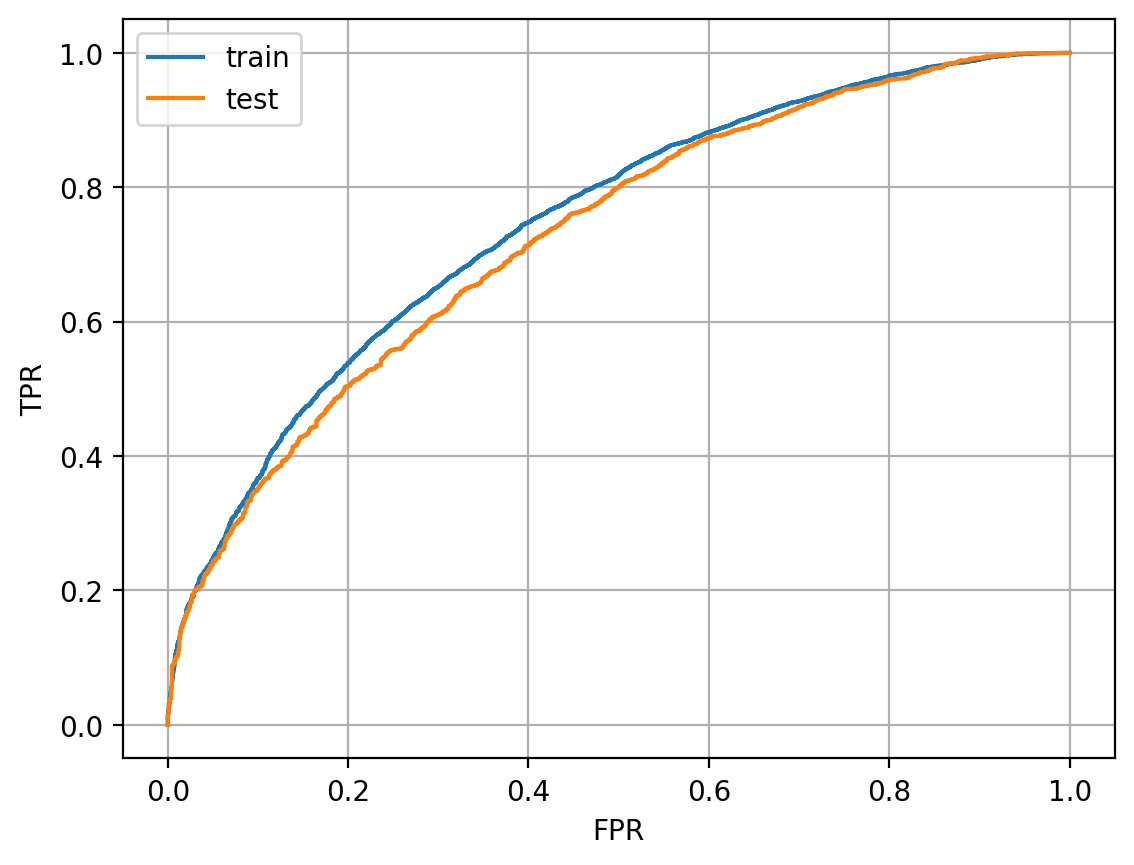

In [29]:
y_pred_test_vot = voting_clf.predict_proba(X_test)[:, 1]
y_pred_train_vot = voting_clf.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_train_vot, 'train')
print('Test:')
calc_auc(y_test, y_pred_test_vot, 'test')
plt.grid()
plt.legend();

## Композиции моделей одного семейства

### Бэггинг

Самостоятельная реализация

##### На дереве

In [30]:
%%time
from sklearn.ensemble import BaggingClassifier

bag_clf = BaggingClassifier(n_estimators=20, base_estimator=clf_tree, n_jobs=-1, max_features=0.8, random_state=42)
bag_clf.fit(X_train, y_train)

CPU times: total: 93.8 ms
Wall time: 3.43 s


BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5,
                                                        min_samples_leaf=10,
                                                        random_state=42),
                  max_features=0.8, n_estimators=20, n_jobs=-1,
                  random_state=42)

Train:
ROC AUC: 0.7535
Test:
ROC AUC: 0.7231


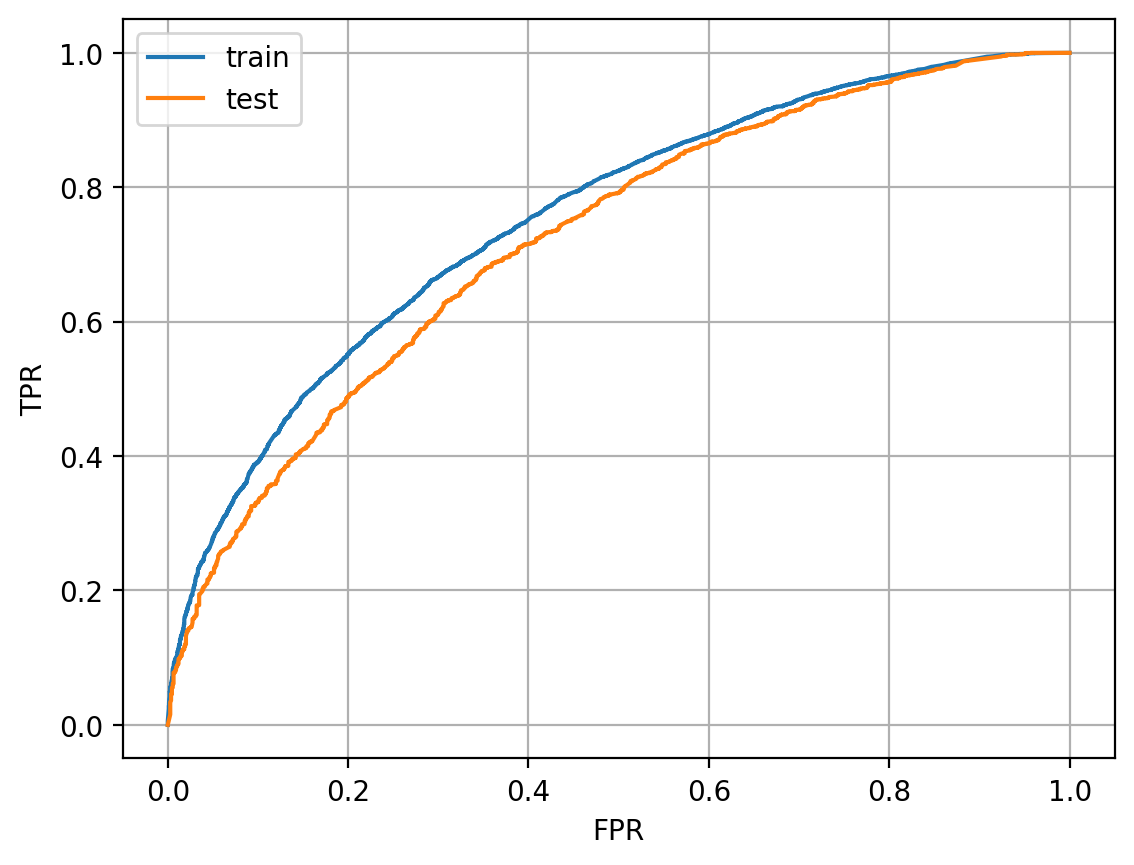

In [31]:
y_pred_test_bg = bag_clf.predict_proba(X_test)[:, 1]
y_pred_train_bg = bag_clf.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_train_bg, 'train')
print('Test:')
calc_auc(y_test, y_pred_test_bg, 'test')
plt.grid()
plt.legend();

##### Логистический

In [32]:
%%time
bag_clf_lr = BaggingClassifier(n_estimators=20, base_estimator=clf_lr, n_jobs=-1, random_state=42)
bag_clf_lr.fit(X_train, y_train)

CPU times: total: 46.9 ms
Wall time: 14.3 s


BaggingClassifier(base_estimator=LogisticRegression(C=0.01, random_state=42),
                  n_estimators=20, n_jobs=-1, random_state=42)

Train:
ROC AUC: 0.7353
Test:
ROC AUC: 0.7224


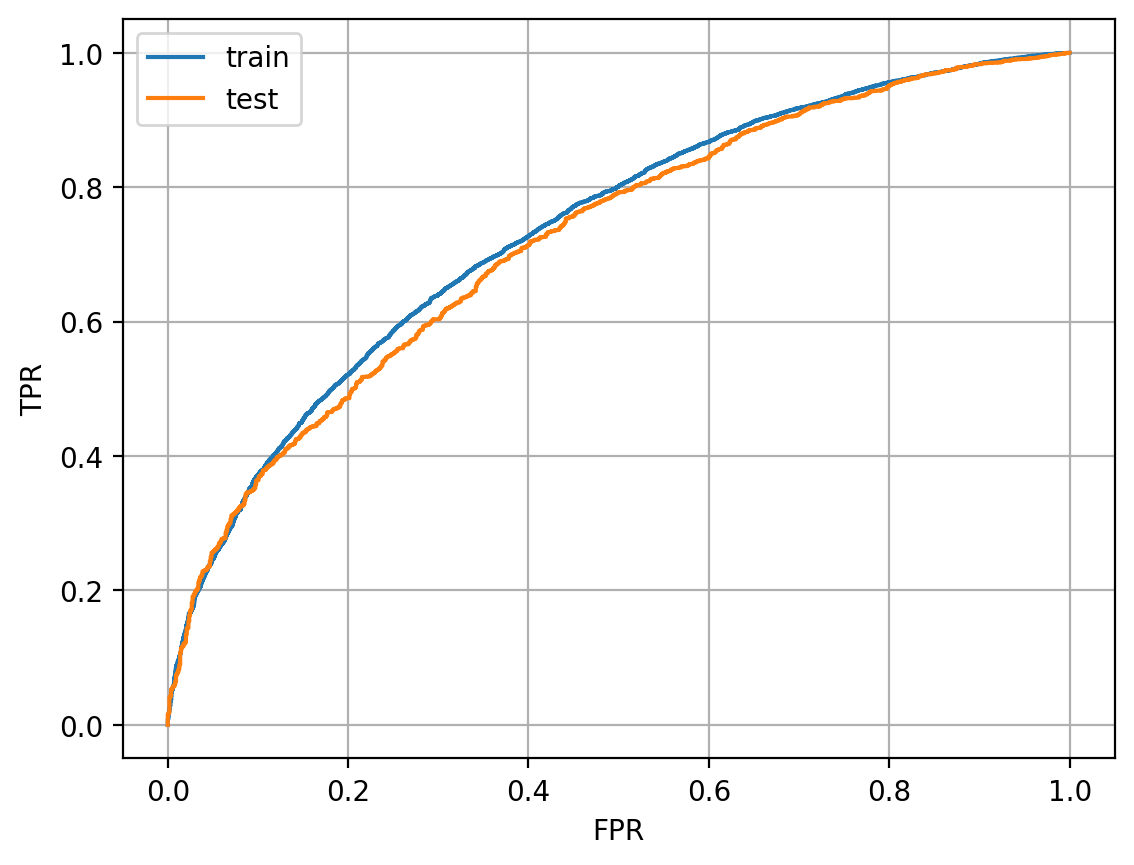

In [33]:
y_pred_test_bgLR = bag_clf_lr.predict_proba(X_test)[:, 1]
y_pred_train_bgLR = bag_clf_lr.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_train_bgLR, 'train')
print('Test:')
calc_auc(y_test, y_pred_test_bgLR, 'test')
plt.grid()
plt.legend();

In [34]:
bag_clf_lr

()

# Часть 2. Случайный лес


**Важные гиперпараметры алгоритма**

a. Параметры деревьев
    1. criterion - критерий построения дерева
    2. max_depth - максимальная глубина дерева (обычно 10-20, больше глубина -> больше риск переобучения)
    3. min_samples_leaf - минимальное число объектов в листе (обычно 20+, больше объектов -> меньше риск переобучения)

b. Параметры леса
    1. n_estimators - кол-во деревьев (чем больше тем лучше)
    2. max_features - число признаков случайного подпространства
    3. bootstrap - использовать ли бэггинг
    4. n_jobs - кол-во потоков для одновременного построения деревьев (большая прибавка к скорости на многоядерных процах)

In [35]:
%%time
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=100, max_depth=7, min_samples_split=14, random_state=42, 
                                criterion='entropy', min_samples_leaf=20, max_features=0.8, n_jobs=-1)

clf_rf.fit(X_train, y_train)    

CPU times: total: 1min 46s
Wall time: 17.8 s


RandomForestClassifier(criterion='entropy', max_depth=7, max_features=0.8,
                       min_samples_leaf=20, min_samples_split=14, n_jobs=-1,
                       random_state=42)

Train:
ROC AUC: 0.7914
Test:
ROC AUC: 0.7298


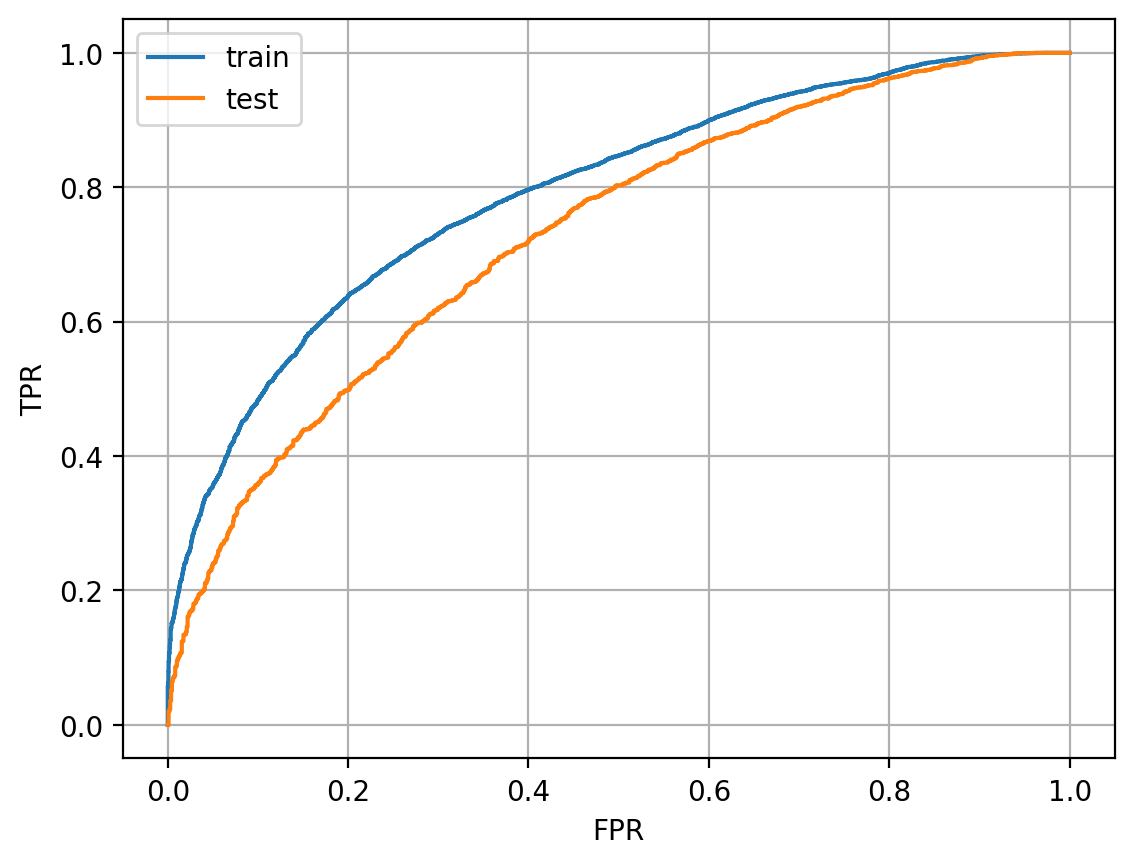

In [36]:
y_pred_rf_test = clf_rf.predict_proba(X_test)[:, 1]
y_pred_rf_train = clf_rf.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_rf_train , 'train')
print('Test:')
calc_auc(y_test, y_pred_rf_test, 'test')
plt.grid()
plt.legend();

#### Важность признаков

В sklearn - усредненное по всем деревьям в ансамбле кол-во сплитов по признаку, взвешенное на прирост информации (Information gain) и долю объектов в вершине, в которой производится этот сплит

Это не единственный вариант, см здесь:

https://medium.com/@ceshine/feature-importance-measures-for-tree-models-part-i-47f187c1a2c3

Важности признаков случайного леса лежат в артибуте **feature\_importances\_**

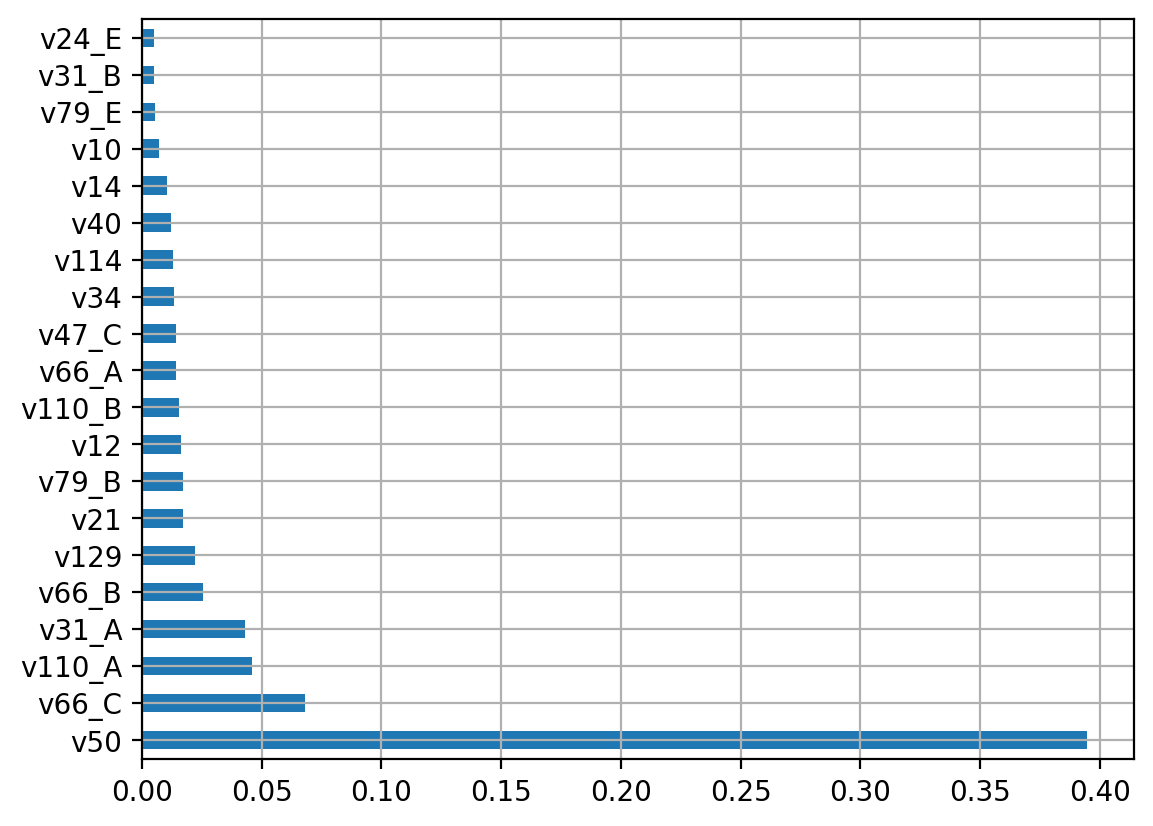

In [37]:
imp = pd.Series(clf_rf.feature_importances_, index=X_norm.columns).sort_values(ascending=False).iloc[:20].plot(kind='barh')
plt.grid();

### Особо случайное дерево

In [38]:
from sklearn.ensemble import ExtraTreesClassifier

In [39]:
clf_Erf = ExtraTreesClassifier(n_estimators=100, max_depth=7, min_samples_split=14, random_state=42, 
                                criterion='entropy', min_samples_leaf=20, max_features=0.8, n_jobs=-1)

In [40]:
%%time
clf_Erf.fit(X_train, y_train)

CPU times: total: 40.4 s
Wall time: 7.57 s


ExtraTreesClassifier(criterion='entropy', max_depth=7, max_features=0.8,
                     min_samples_leaf=20, min_samples_split=14, n_jobs=-1,
                     random_state=42)

Train:
ROC AUC: 0.7659
Test:
ROC AUC: 0.7306


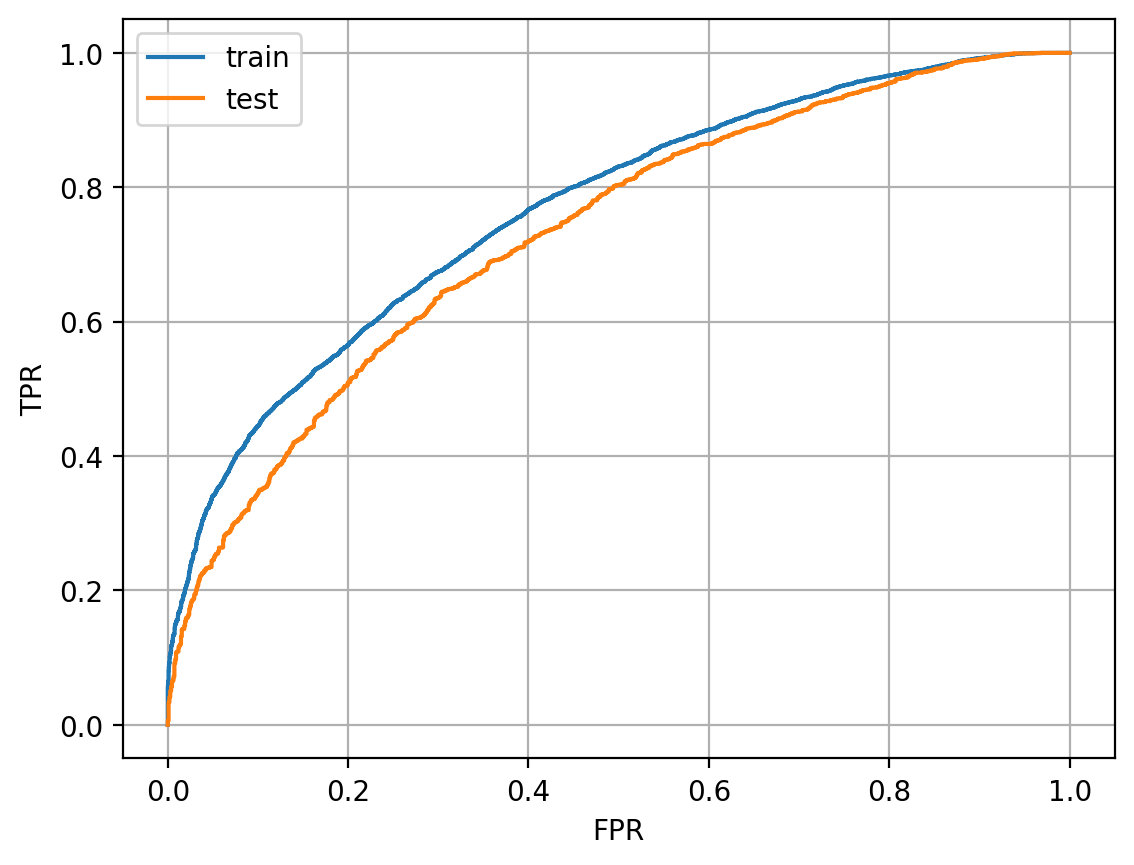

In [41]:
y_pred_Erf_test = clf_Erf.predict_proba(X_test)[:, 1]
y_pred_Erf_train = clf_Erf.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_Erf_train , 'train')
print('Test:')
calc_auc(y_test, y_pred_Erf_test, 'test')
plt.grid()
plt.legend();

# Часть 3. Композиции моделей разных типов

### Линейная комбинация моделей разного типа

Смешаем дерево и логистическую регрессию

Будем строить линейную комбинацию вида

$y = \alpha y_1 + (1 - \alpha) y_2$

Параметр $\alpha$ переберем по сетке от 0 до 1, оценивая качество на тестовой выборке

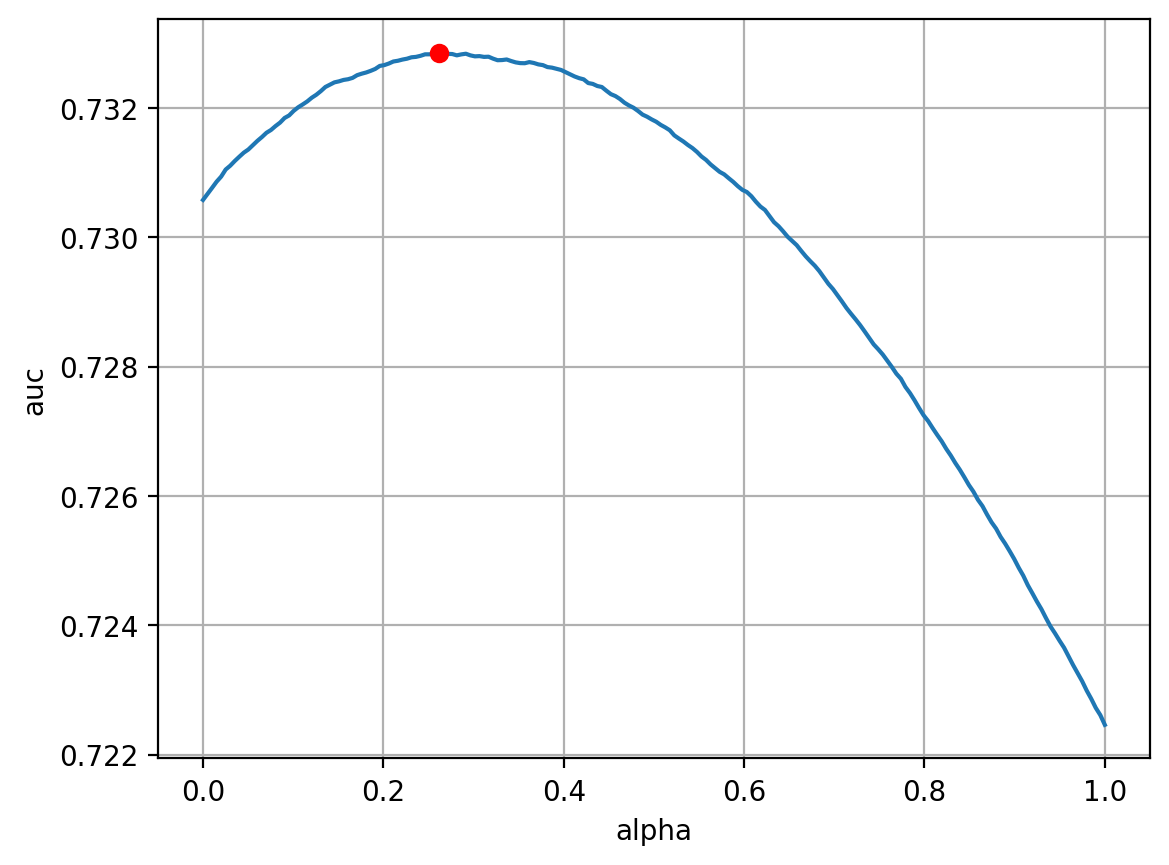

In [43]:
aucs = []
alpha_space = np.linspace(0, 1, 200)
for alpha in alpha_space:
    y_pred_weight = alpha * y_pred_lin_test + (1 - alpha) * y_pred_Erf_test
    aucs.append(calc_auc(y_test, y_pred_weight, prin=False))
aucs = np.array(aucs)    

max_ind = np.where(aucs == aucs.max())[0]
alpha = alpha_space[max_ind]

plt.plot(alpha_space, aucs)
plt.plot(alpha_space[max_ind], aucs[max_ind], 'o', c='r')
plt.xlabel('alpha')
plt.ylabel('auc')
plt.grid()

#итоговое взвешенное предсказание
y_pred_weight = alpha * y_pred_lin_test + (1 - alpha) * y_pred_Erf_test

Weighted:
ROC AUC: 0.7329
Log regression:
ROC AUC: 0.7225
ExtraTrees:
ROC AUC: 0.7306


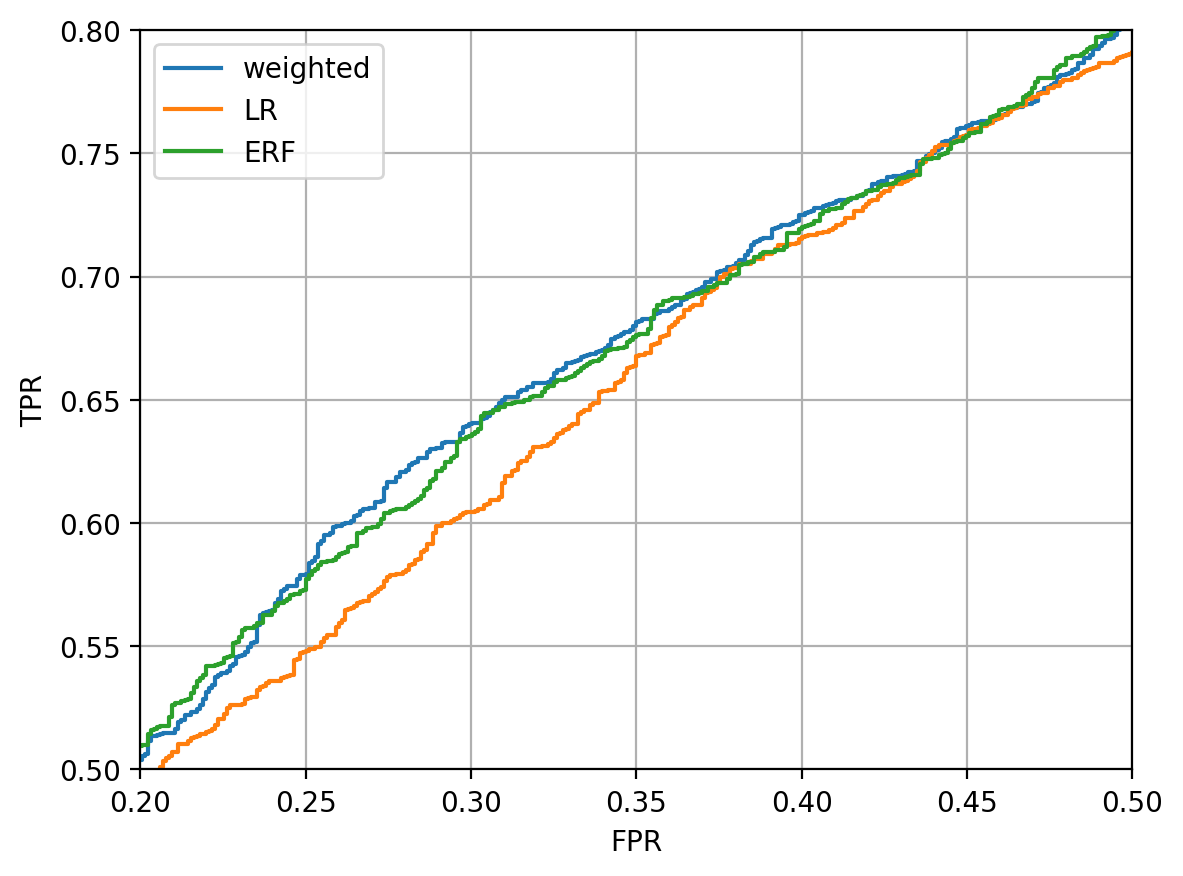

In [44]:
print('Weighted:')
calc_auc(y_test, y_pred_weight, 'weighted')
print('Log regression:')
calc_auc(y_test, y_pred_lin_test, 'LR')
print('ExtraTrees:')
calc_auc(y_test, y_pred_Erf_test, 'ERF')
plt.legend();
plt.xlim(0.2, 0.5)
plt.ylim(0.5, 0.8)
plt.grid();

## Стэкинг

### StackingClassifier

In [45]:
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import make_pipeline

In [47]:
estimators = [
            ('rf', clf_rf),
            ('Etree', clf_Erf),
            ('Bagg',bag_clf)
            ]

In [48]:
Stac_clf = StackingClassifier(estimators=estimators, 
                              final_estimator=clf_Erf, n_jobs=-1, verbose=3)

In [49]:
%%time
Stac_clf.fit(X_train, y_train)

CPU times: total: 656 ms
Wall time: 2min 11s


StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(criterion='entropy',
                                                       max_depth=7,
                                                       max_features=0.8,
                                                       min_samples_leaf=20,
                                                       min_samples_split=14,
                                                       n_jobs=-1,
                                                       random_state=42)),
                               ('Etree',
                                ExtraTreesClassifier(criterion='entropy',
                                                     max_depth=7,
                                                     max_features=0.8,
                                                     min_samples_leaf=20,
                                                     min_samples_split=14,
                                                     n_jobs=-1,
                                                     random_state=42)),
                               ('Bagg',
                                BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5,
                                                                                        min_samples_leaf=10,
                                                                                        random_state=42),
                                                  max_features=0.8,
                                                  n_estimators=20, n_jobs=-1,
                                                  random_state=42))],
                   final_estimator=ExtraTreesClassifier(criterion='entropy',
                                                        max_depth=7,
                                                        max_features=0.8,
                                                        min_samples_leaf=20,
                                                        min_samples_split=14,
                                                        n_jobs=-1,
                                                        random_state=42),
                   n_jobs=-1, verbose=3)

Train:
ROC AUC: 0.7769
Test:
ROC AUC: 0.7333


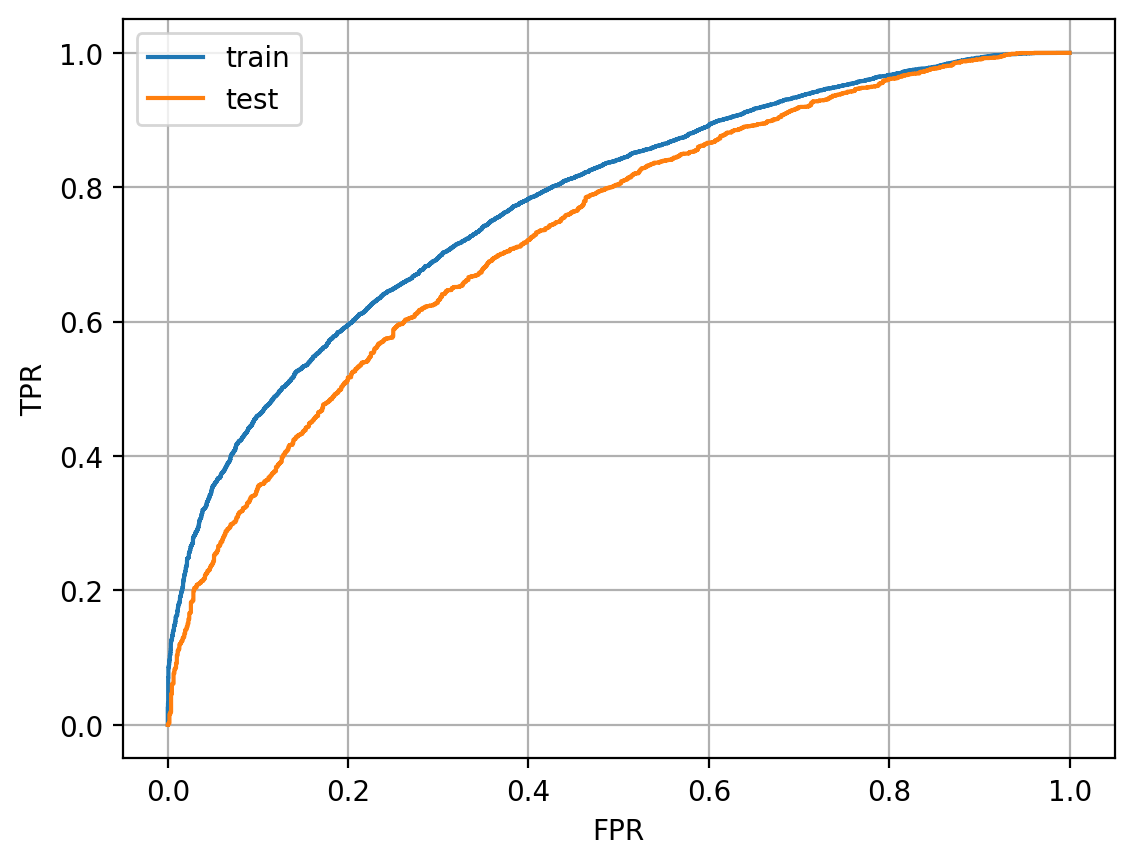

In [50]:
y_pred_Stac_test = Stac_clf.predict_proba(X_test)[:, 1]
y_pred_Stac_train = Stac_clf.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_Stac_train , 'train')
print('Test:')
calc_auc(y_test, y_pred_Stac_test, 'test')
plt.grid()
plt.legend();

## Бустинг в sklearn

In [51]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

#### Adaboost

Train:
ROC AUC: 0.7516
Test:
ROC AUC: 0.7311
CPU times: total: 28.4 s
Wall time: 28.8 s


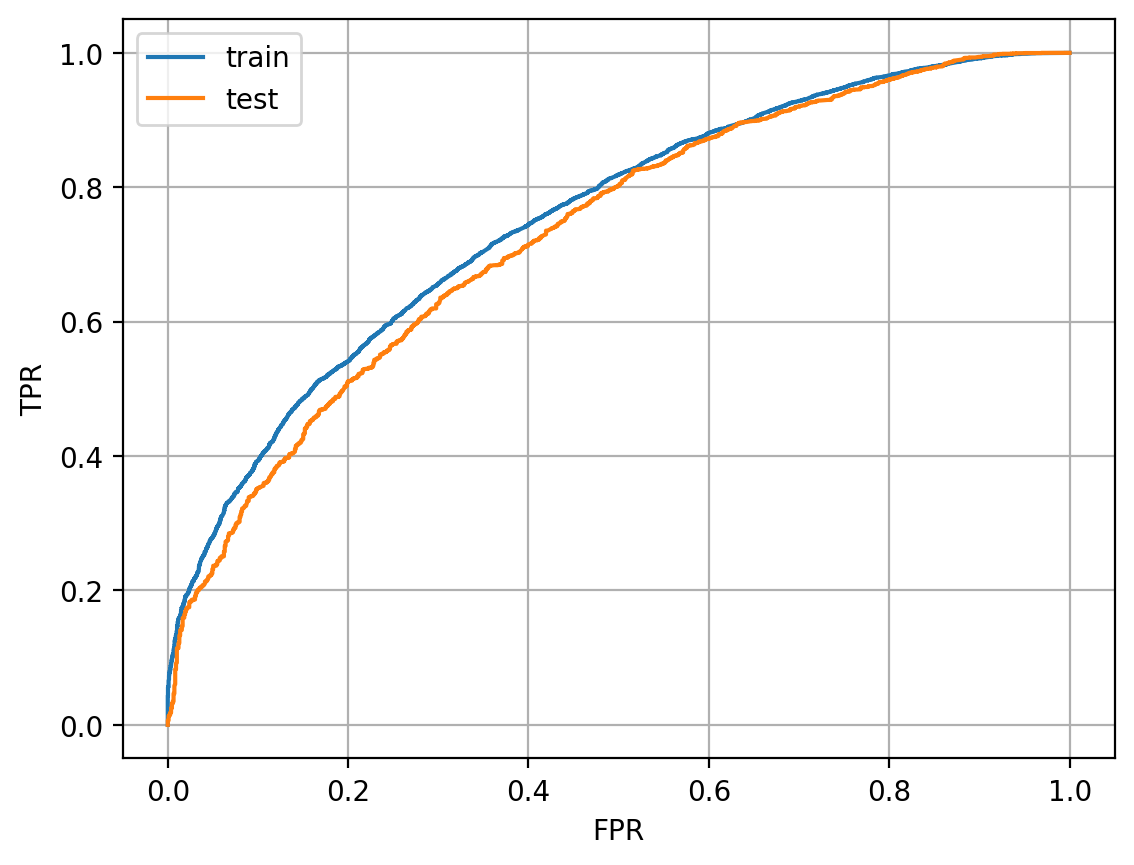

In [52]:
%%time
clf_ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2, min_samples_leaf=30, max_features=0.8, min_samples_split=30),
                             n_estimators=100, learning_rate=0.1, random_state=42)

clf_ada.fit(X_train, y_train)
y_pred_ada_test = clf_ada.predict_proba(X_test)[:, 1]
y_pred_ada_train = clf_ada.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_ada_train, 'train')
print('Test:')
calc_auc(y_test, y_pred_ada_test, 'test')
plt.grid();
plt.legend();

#### GradientBoosting

Train:
ROC AUC: 0.7489
Test:
ROC AUC: 0.7321
Wall time: 17.5 s


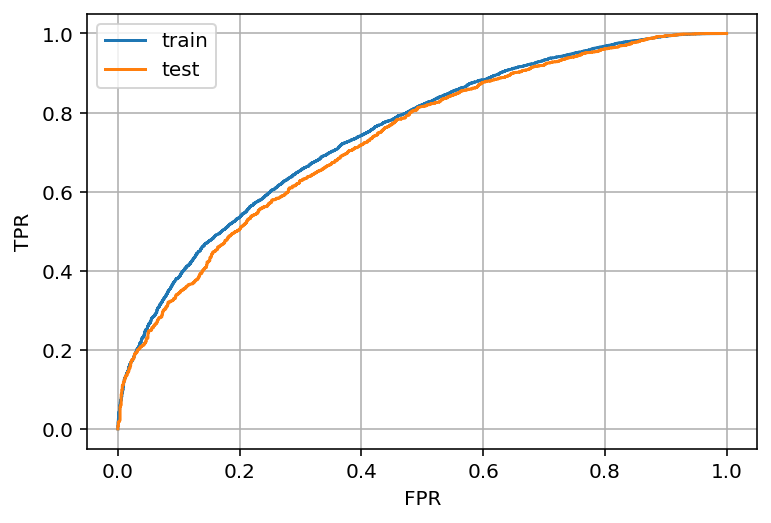

In [ ]:
%%time
clf_gbm = GradientBoostingClassifier(max_depth=2, min_samples_leaf=30, n_estimators=100, learning_rate=0.1, 
                                     subsample=1.0, max_features=0.8, min_samples_split=30, random_state=42, 
                                     verbose=0)
# если subsample < 1.0 - получится стахастический градиентный спуск, алгоритм работать будет быстрее, 
# но точность может быть хуже

clf_gbm.fit(X_train, y_train)
y_pred_gbm_test = clf_gbm.predict_proba(X_test)[:, 1]
y_pred_gbm_train = clf_gbm.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_gbm_train, 'train')
print('Test:')
calc_auc(y_test, y_pred_gbm_test, 'test')
plt.legend()
plt.grid();

## XGBOOST

In [50]:
import xgboost as xgb

**Важные гиперпараметры алгоритма**

a. Параметры деревьев

    1. max_depth - максимальная глубина дерева (обычно 3-10, больше глубина -> больше риск переобучения)
    2. min_child_weight - минимальное число объектов в листе (обычно до 20, больше объектов -> меньше риск переобучения, но должен быть согласован с глубиной дерева)
    3. gamma - минимально необходимый прирост качества для разбиения листа (редко используется)

b. Параметры бустинга

    0. objective - оптимизируемый функционал (встроен для классификации и регрессии, можно написать свой дифференцируемый)
    1. n_estimators - кол-во базовых алгоритмов (чем меньше learning_rate, тем больше деревьев)
    2. learning_rate - шаг создания ансамбля (зависит от n_estimators, но обычно 0.01 - 0.1)
    2. colsample_bytree - доля признаков, случайно выбирающихся для построения дерева
    3. subsample - доля объектов, случайно выбирающихся для построения дерева
    4. n_jobs - кол-во потоков для одновременного построения деревьев (большая прибавка к скорости на многоядерных процах)
    5. reg_alpha - вес L1 регуляризации (редко используется)
    6. reg_lambda - вес L2 регуляризации (редко используется)

Параметры по умолчанию

In [ ]:
params = {'n_estimators': 100,
          'learning_rate': 0.1,
          'max_depth': 3,
          'min_child_weight': 1,
          'subsample': 1,
          'colsample_bytree': 1,
          'n_jobs': -1}

In [ ]:
%%time
clf_xgb = xgb.XGBClassifier(**params)
clf_xgb.fit(X_train, y_train)

Wall time: 2.58 s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=3, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

Train:
ROC AUC: 0.7738
Test:
ROC AUC: 0.7332


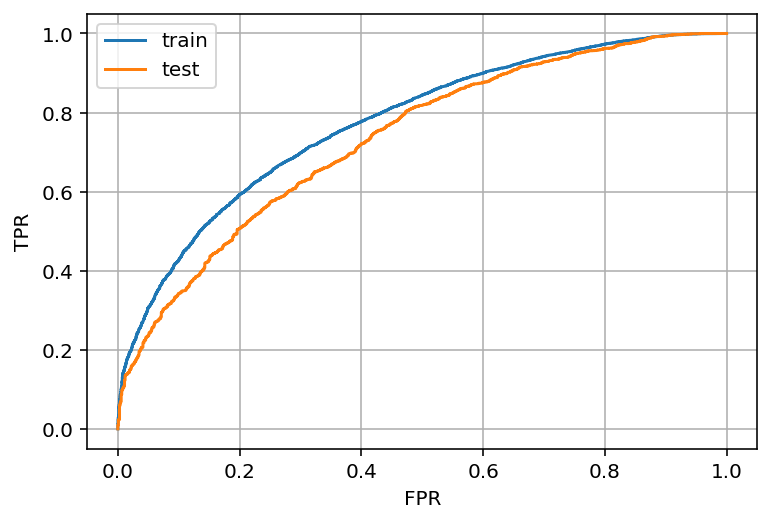

In [ ]:
y_pred_xgb_test = clf_xgb.predict_proba(X_test)[:, 1]
y_pred_xgb_train = clf_xgb.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_xgb_train, 'train')
print('Test:')
calc_auc(y_test, y_pred_xgb_test, 'test')
plt.grid()
plt.legend();

#### Онлайн оценка качества 

Во время обучения можно следить за качеством во время каждой итерации

Для этого используются параметры:
    1. eval_metric - метрика 'auc', 'rmse', 'logloss', ...
    2. eval_set - список выборок вида [(X, y), ...] на которых тестировать алгоритм

In [55]:
params = {'n_estimators': 100,
          'learning_rate': 0.1,
          'max_depth': 3,
          'min_child_weight': 1,
          'subsample': 1,
          'colsample_bytree': 1,
          'n_jobs': -1}
clf_xgb = xgb.XGBClassifier(**params)

clf_xgb.fit(X_train, y_train, eval_metric='auc', eval_set=[[X_train, y_train], [X_test, y_test]])

[0]	validation_0-auc:0.69674	validation_1-auc:0.69443
[1]	validation_0-auc:0.71393	validation_1-auc:0.71238
[2]	validation_0-auc:0.71513	validation_1-auc:0.71369
[3]	validation_0-auc:0.71860	validation_1-auc:0.71721
[4]	validation_0-auc:0.72114	validation_1-auc:0.71825
[5]	validation_0-auc:0.72341	validation_1-auc:0.72021
[6]	validation_0-auc:0.72543	validation_1-auc:0.72188
[7]	validation_0-auc:0.72579	validation_1-auc:0.72340
[8]	validation_0-auc:0.72627	validation_1-auc:0.72334
[9]	validation_0-auc:0.72669	validation_1-auc:0.72431
[10]	validation_0-auc:0.72729	validation_1-auc:0.72533
[11]	validation_0-auc:0.72785	validation_1-auc:0.72466
[12]	validation_0-auc:0.72820	validation_1-auc:0.72580
[13]	validation_0-auc:0.72952	validation_1-auc:0.72708
[14]	validation_0-auc:0.73114	validation_1-auc:0.72687
[15]	validation_0-auc:0.73163	validation_1-auc:0.72722
[16]	validation_0-auc:0.73169	validation_1-auc:0.72783
[17]	validation_0-auc:0.73292	validation_1-auc:0.72777
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=3, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

#### Возмем параметры, с которых лучше всего начать

In [56]:
%%time

params = {'n_estimators': 100,
          'learning_rate': 0.1,
          'max_depth': 5,
          'min_child_weight': 1,
          'subsample': 0.8,
          'colsample_bytree': 0.8,
          'n_jobs': -1}
clf_xgb = xgb.XGBClassifier(**params)

clf_xgb.fit(X_train, y_train, eval_metric='auc', eval_set=[[X_train, y_train], [X_test, y_test]])

[0]	validation_0-auc:0.73255	validation_1-auc:0.71462
[1]	validation_0-auc:0.74290	validation_1-auc:0.71973
[2]	validation_0-auc:0.74929	validation_1-auc:0.72283
[3]	validation_0-auc:0.75078	validation_1-auc:0.72373
[4]	validation_0-auc:0.75269	validation_1-auc:0.72409
[5]	validation_0-auc:0.75419	validation_1-auc:0.72402
[6]	validation_0-auc:0.75629	validation_1-auc:0.72429
[7]	validation_0-auc:0.75768	validation_1-auc:0.72361
[8]	validation_0-auc:0.75888	validation_1-auc:0.72303
[9]	validation_0-auc:0.76137	validation_1-auc:0.72194
[10]	validation_0-auc:0.76275	validation_1-auc:0.72323
[11]	validation_0-auc:0.76444	validation_1-auc:0.72561
[12]	validation_0-auc:0.76608	validation_1-auc:0.72569
[13]	validation_0-auc:0.76646	validation_1-auc:0.72642
[14]	validation_0-auc:0.76703	validation_1-auc:0.72789
[15]	validation_0-auc:0.76840	validation_1-auc:0.72813
[16]	validation_0-auc:0.77021	validation_1-auc:0.72764
[17]	validation_0-auc:0.77143	validation_1-auc:0.72768
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

###### Достанем из объекта clf_xgb списки результатов метрик по итерациям, построим графики

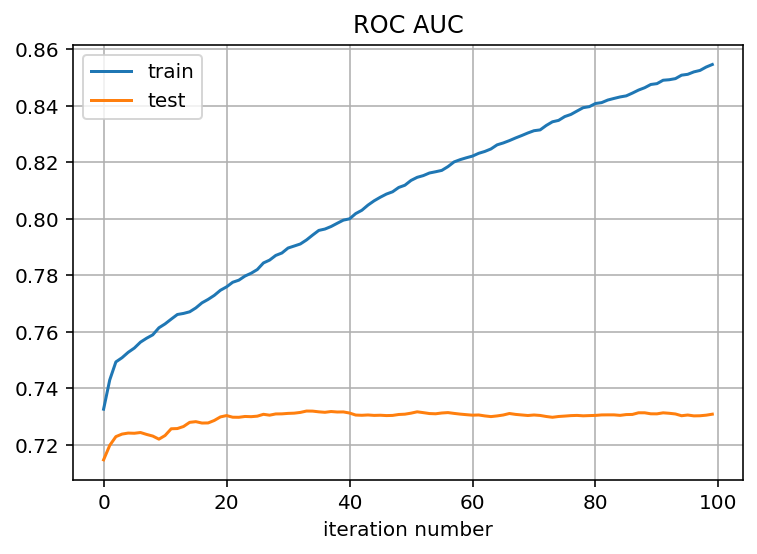

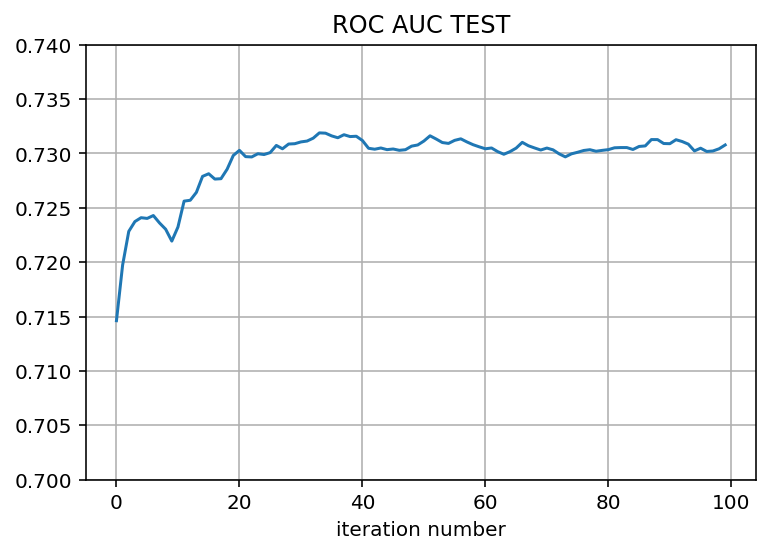

In [57]:
def save_online_metric(clf):
    return pd.DataFrame({'train': clf.evals_result()['validation_0']['auc'],
                         'test': clf.evals_result()['validation_1']['auc']})
res = save_online_metric(clf_xgb)
res.plot(title='ROC AUC')
plt.xlabel('iteration number')
plt.grid();
plt.figure()
res.test.plot(ylim=(0.7, 0.74), title='ROC AUC TEST')
plt.xlabel('iteration number')
plt.grid();

###### Нужно побороть переобучение, уменьшим learning_rate. Также уменьшим кол-во деревьев для ускорения обучения

In [58]:
%%time
params = {'n_estimators': 50,
          'learning_rate': 0.03,
          'max_depth': 5,
          'min_child_weight': 1,
          'subsample': 0.8,
          'colsample_bytree': 0.8,
          'n_jobs': -1}
clf_xgb = xgb.XGBClassifier(**params)

clf_xgb.fit(X_train, y_train, eval_metric='auc', eval_set=[[X_train, y_train], [X_test, y_test]])

best_params = params

[0]	validation_0-auc:0.73255	validation_1-auc:0.71462
[1]	validation_0-auc:0.74125	validation_1-auc:0.71800
[2]	validation_0-auc:0.74476	validation_1-auc:0.72193
[3]	validation_0-auc:0.74705	validation_1-auc:0.72329
[4]	validation_0-auc:0.74833	validation_1-auc:0.72452
[5]	validation_0-auc:0.74926	validation_1-auc:0.72465
[6]	validation_0-auc:0.75092	validation_1-auc:0.72323
[7]	validation_0-auc:0.75254	validation_1-auc:0.72374
[8]	validation_0-auc:0.75322	validation_1-auc:0.72422
[9]	validation_0-auc:0.75458	validation_1-auc:0.72302
[10]	validation_0-auc:0.75506	validation_1-auc:0.72323
[11]	validation_0-auc:0.75575	validation_1-auc:0.72373
[12]	validation_0-auc:0.75651	validation_1-auc:0.72376
[13]	validation_0-auc:0.75704	validation_1-auc:0.72467
[14]	validation_0-auc:0.75706	validation_1-auc:0.72525
[15]	validation_0-auc:0.75750	validation_1-auc:0.72500
[16]	validation_0-auc:0.75858	validation_1-auc:0.72507
[17]	validation_0-auc:0.75884	validation_1-auc:0.72478
[18]	validation_0-au

### Перебор параметров по сетке

Опишем функцию, похожую на GridSearchCV, только для одной отложенной выборки X_test. Она перебирает параметки по заданной сетке и возврашает лучшие по ROC AUC

In [67]:
from sklearn.model_selection import GridSearchCV
def find_params(clf, param_grid):
    clf = GridSearchCV(clf, param_grid, scoring='roc_auc', cv=[(np.arange(len(X_train)),
                                                               np.arange(len(X_test)) + len(X_train))],
                  verbose=3)

    clf.fit(pd.concat([X_train, X_test]).values, pd.concat([y_train, y_test]).values)
    best_params = clf.best_estimator_.get_params()
    print('Best test ROC AUC: ', clf.best_score_)
    print('Best params: ', best_params)
    return best_params

**Процесс подбора параметров**:

1. Зафиксируем learning_rate и n_estimators, чтобы модель не переобучалась во время итераций
2. Настраиваем параметры деревьев: max_depth и min_child_weight
3. Настраиваем gamma (опционально)
4. Настраиваем subsample и colsample_bytree
5. Настраиваем регуляризацию reg_lambda и reg_alpha
6. Уменьшаем learning_rate, увеличиваем кол-во деревьев и обучаем заново на лучших параметрах

#### Подбираем max_depth и min_child_weight

In [68]:
%%time

from sklearn.model_selection import GridSearchCV

clf_xgb = xgb.XGBClassifier(**best_params)

param_grid = {
    'max_depth': [3, 5, 10],
    'min_child_weight': [10, 20, 100]#[1, 5, 10]
}

best_params = find_params(clf_xgb, param_grid)

Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV 1/1] END ..max_depth=3, min_child_weight=10;, score=0.732 total time=   8.2s
[CV 1/1] END ..max_depth=3, min_child_weight=20;, score=0.732 total time=   8.1s
[CV 1/1] END .max_depth=3, min_child_weight=100;, score=0.731 total time=   7.8s
[CV 1/1] END ..max_depth=5, min_child_weight=10;, score=0.734 total time=  12.3s
[CV 1/1] END ..max_depth=5, min_child_weight=20;, score=0.734 total time=  12.1s
[CV 1/1] END .max_depth=5, min_child_weight=100;, score=0.731 total time=  11.0s
[CV 1/1] END .max_depth=10, min_child_weight=10;, score=0.732 total time=  23.0s
[CV 1/1] END .max_depth=10, min_child_weight=20;, score=0.731 total time=  22.0s
[CV 1/1] END max_depth=10, min_child_weight=100;, score=0.732 total time=  16.2s
Best test ROC AUC:  0.734261238139434
Best params:  {'objective': 'binary:logistic', 'use_label_encoder': None, 'base_score': 0.5, 'booster': 'gbtree', 'callbacks': None, 'colsample_bylevel': 1, 'colsample_bynode

#### Подбираем gamma

In [69]:
%%time

clf_xgb = xgb.XGBClassifier(**best_params)

param_grid = {
    'gamma': np.linspace(0, 0.5, 5)
}

best_params = find_params(clf_xgb, param_grid)

Fitting 1 folds for each of 5 candidates, totalling 5 fits
[CV 1/1] END .........................gamma=0.0;, score=0.734 total time=  11.9s
[CV 1/1] END .......................gamma=0.125;, score=0.734 total time=  12.0s
[CV 1/1] END ........................gamma=0.25;, score=0.735 total time=  12.0s
[CV 1/1] END .......................gamma=0.375;, score=0.734 total time=  12.1s
[CV 1/1] END .........................gamma=0.5;, score=0.734 total time=  12.6s
Best test ROC AUC:  0.7345202317552215
Best params:  {'objective': 'binary:logistic', 'use_label_encoder': None, 'base_score': 0.5, 'booster': 'gbtree', 'callbacks': None, 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.7, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 0.25, 'gpu_id': -1, 'grow_policy': 'depthwise', 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.01, 'max_bin': 256, 'max_cat_threshold': 64, 'max_cat_to

#### Подбираем subsample и colsample_bytree

In [70]:
%%time
clf_xgb = xgb.XGBClassifier(**best_params)

param_grid = {
    'subsample': np.linspace(0.5, 1, 6),
    'colsample_bytree': np.linspace(0.5, 1, 6)
}

best_params = find_params(clf_xgb, param_grid)

Fitting 1 folds for each of 36 candidates, totalling 36 fits
[CV 1/1] END colsample_bytree=0.5, subsample=0.5;, score=0.734 total time=   9.3s
[CV 1/1] END colsample_bytree=0.5, subsample=0.6;, score=0.733 total time=   9.7s
[CV 1/1] END colsample_bytree=0.5, subsample=0.7;, score=0.735 total time=   9.3s
[CV 1/1] END colsample_bytree=0.5, subsample=0.8;, score=0.734 total time=   9.3s
[CV 1/1] END colsample_bytree=0.5, subsample=0.9;, score=0.735 total time=   9.7s
[CV 1/1] END colsample_bytree=0.5, subsample=1.0;, score=0.734 total time=   9.4s
[CV 1/1] END colsample_bytree=0.6, subsample=0.5;, score=0.733 total time=  11.0s
[CV 1/1] END colsample_bytree=0.6, subsample=0.6;, score=0.734 total time=  10.9s
[CV 1/1] END colsample_bytree=0.6, subsample=0.7;, score=0.735 total time=  10.7s
[CV 1/1] END colsample_bytree=0.6, subsample=0.8;, score=0.735 total time=  11.4s
[CV 1/1] END colsample_bytree=0.6, subsample=0.9;, score=0.734 total time=  12.2s
[CV 1/1] END colsample_bytree=0.6, su

#### Подбираем регуляризацию: reg_lambda и reg_alpha

In [71]:
%%time

clf_xgb = xgb.XGBClassifier(**best_params)

param_grid = {
    'reg_alpha': [0, 0.0001, 0.001, 0.1, 1],
    'reg_lambda': [0, 0.0001, 0.001, 0.1, 1]
}

best_params = find_params(clf_xgb, param_grid)

Fitting 1 folds for each of 25 candidates, totalling 25 fits
[CV 1/1] END .........reg_alpha=0, reg_lambda=0;, score=0.735 total time=  11.3s
[CV 1/1] END ....reg_alpha=0, reg_lambda=0.0001;, score=0.736 total time=  11.4s
[CV 1/1] END .....reg_alpha=0, reg_lambda=0.001;, score=0.736 total time=  11.1s
[CV 1/1] END .......reg_alpha=0, reg_lambda=0.1;, score=0.736 total time=  11.0s
[CV 1/1] END .........reg_alpha=0, reg_lambda=1;, score=0.736 total time=  11.3s
[CV 1/1] END ....reg_alpha=0.0001, reg_lambda=0;, score=0.736 total time=  11.7s
[CV 1/1] END reg_alpha=0.0001, reg_lambda=0.0001;, score=0.736 total time=  11.9s
[CV 1/1] END reg_alpha=0.0001, reg_lambda=0.001;, score=0.736 total time=  11.7s
[CV 1/1] END ..reg_alpha=0.0001, reg_lambda=0.1;, score=0.736 total time=  11.7s
[CV 1/1] END ....reg_alpha=0.0001, reg_lambda=1;, score=0.736 total time=  11.7s
[CV 1/1] END .....reg_alpha=0.001, reg_lambda=0;, score=0.736 total time=  11.9s
[CV 1/1] END reg_alpha=0.001, reg_lambda=0.0001

#### Уменьшим learning_rate

In [72]:
%%time

best_params['learning_rate'] = 0.01
best_params['n_estimators'] = 500

clf_xgb = xgb.XGBClassifier(**best_params)

clf_xgb.fit(X_train, y_train, eval_metric='auc', eval_set=[[X_train, y_train], [X_test, y_test]])

[0]	validation_0-auc:0.68887	validation_1-auc:0.66010
[1]	validation_0-auc:0.73220	validation_1-auc:0.70867
[2]	validation_0-auc:0.73495	validation_1-auc:0.70915
[3]	validation_0-auc:0.73959	validation_1-auc:0.71657
[4]	validation_0-auc:0.74321	validation_1-auc:0.71884
[5]	validation_0-auc:0.74332	validation_1-auc:0.71544
[6]	validation_0-auc:0.74633	validation_1-auc:0.71684
[7]	validation_0-auc:0.74788	validation_1-auc:0.71877
[8]	validation_0-auc:0.74869	validation_1-auc:0.72033
[9]	validation_0-auc:0.74932	validation_1-auc:0.71887
[10]	validation_0-auc:0.75001	validation_1-auc:0.72026
[11]	validation_0-auc:0.74991	validation_1-auc:0.72118
[12]	validation_0-auc:0.74939	validation_1-auc:0.72104
[13]	validation_0-auc:0.74996	validation_1-auc:0.72143
[14]	validation_0-auc:0.75027	validation_1-auc:0.72221
[15]	validation_0-auc:0.75101	validation_1-auc:0.72267
[16]	validation_0-auc:0.75115	validation_1-auc:0.72196
[17]	validation_0-auc:0.75113	validation_1-auc:0.72242
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.25, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=10, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

###### Визуализируем метрику в зависимости от итерации

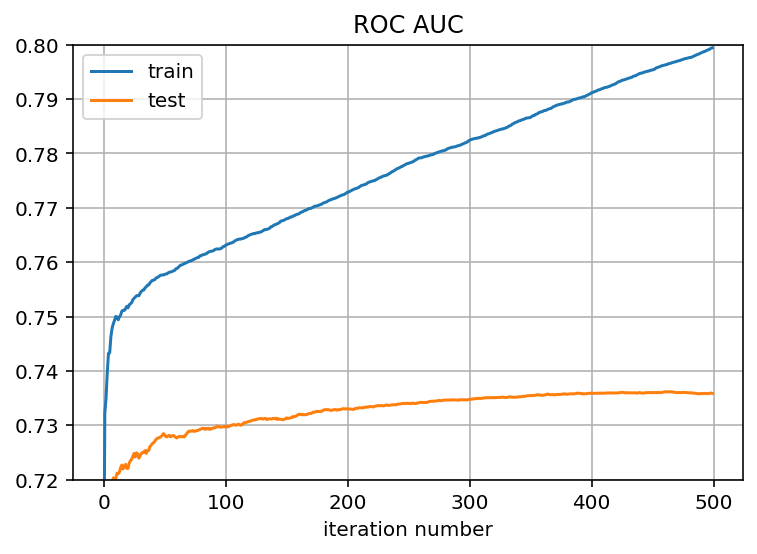

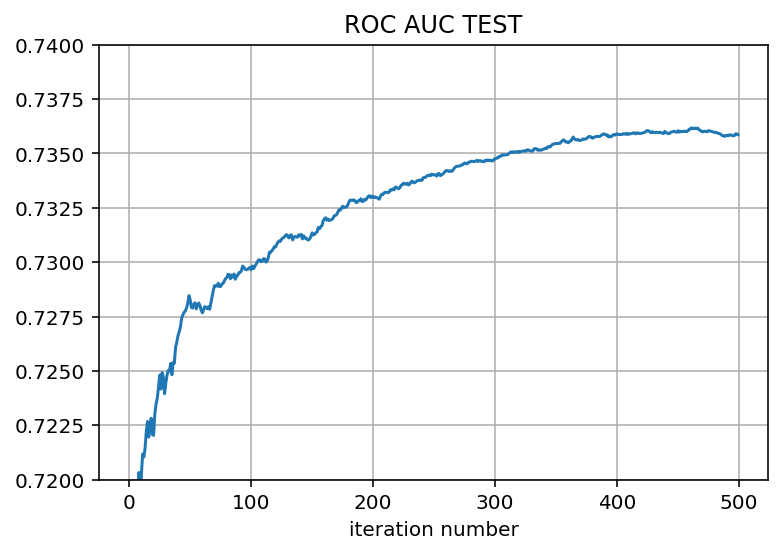

In [73]:
res = save_online_metric(clf_xgb)
res.plot(ylim=(0.72, 0.8), title='ROC AUC')
plt.xlabel('iteration number')
plt.grid();
plt.figure()
res.test.plot(ylim=(0.72, 0.74), title='ROC AUC TEST')
plt.xlabel('iteration number')
plt.grid();

### HyperOpt

http://hyperopt.github.io/hyperopt/

Инструмент для автоматической "умной" оптимизации большого числа гиперпараметров. Использует алгоритм Tree of Parzen Estimators.

Основная идея библиотеки hyperopt — это построение математической гипотезы о том как выглядит функция результа на множества параметров и проверка этой гипотезы с каждой итерацией.

In [51]:
%%time

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

#функция, которую будем МИНИМИЗИРОВАТЬ
def score(params):
    params['max_depth'] = int(params['max_depth'])
    params['n_jobs'] = -1
    print("Training with params : ", params)
    clf = xgb.XGBClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred_xgb_test = clf.predict_proba(X_test)[:, 1]
    auc = calc_auc(y_test, y_pred_xgb_test, prin=False)
    result = {'loss': 1-auc, 'status': STATUS_OK}
    print('TEST ROC AUC: {0:.4f}'.format(auc))
    return result



space = {'max_depth' : hp.quniform('max_depth', 1, 10, 1),
         'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
         'subsample' : hp.quniform('subsample', 0.5, 1, 0.05),
         'gamma' : hp.quniform('gamma', 0.5, 1, 0.05),
         'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05),
         'silent' : 1,
         'n_estimators': 100,
         'learning_rate': 0.1
         }
trials = Trials()

best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=20)

Training with params :                                
{'colsample_bytree': 0.9, 'gamma': 0.7000000000000001, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5.0, 'n_estimators': 100, 'silent': 1, 'subsample': 0.9500000000000001, 'n_jobs': -1}
[15:12:49] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

TEST ROC AUC: 0.7321                                  
Training with params :                                                           
{'colsample_bytree': 0.65, 'gamma': 0.75, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 6.0, 'n_estimators': 100, 'silent': 1, 'subsample': 0.65, 'n_jobs': -1}
[15:12:51] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

TEST ROC AUC: 0.7317                         

In [52]:
best

{'colsample_bytree': 0.9,
 'gamma': 0.5,
 'max_depth': 3.0,
 'min_child_weight': 8.0,
 'subsample': 0.6000000000000001}

In [60]:
trials.best_trial

{'state': 2,
 'tid': 2,
 'spec': None,
 'result': {'loss': 0.26302925983333925, 'status': 'ok'},
 'misc': {'tid': 2,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'colsample_bytree': [2],
   'gamma': [2],
   'max_depth': [2],
   'min_child_weight': [2],
   'subsample': [2]},
  'vals': {'colsample_bytree': [0.9],
   'gamma': [0.5],
   'max_depth': [3.0],
   'min_child_weight': [8.0],
   'subsample': [0.6000000000000001]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2022, 12, 13, 12, 12, 54, 87000),
 'refresh_time': datetime.datetime(2022, 12, 13, 12, 12, 56, 510000)}

#### Построение по лучшим параметрам

In [61]:
best_new = {'colsample_bytree': 0.75,
 'gamma': 0.75,
 'max_depth': 3,
 'min_child_weight': 3.0,
 'subsample': 0.6000000000000001,
 'n_estimators': 100,
 'learning_rate': 0.1         
}

In [57]:
best_new = {'colsample_bytree': 0.9,
 'gamma': 0.5,
 'max_depth': 3,
 'min_child_weight': 8.0,
 'subsample': 0.6000000000000001}

In [62]:
%%time
clf_xgb = xgb.XGBClassifier(**best_new)
clf_xgb.fit(X_train, y_train)

Wall time: 2.19 s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.75,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.75, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=3, max_leaves=0, min_child_weight=3.0, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

Train:
ROC AUC: 0.7732
Test:
ROC AUC: 0.7342


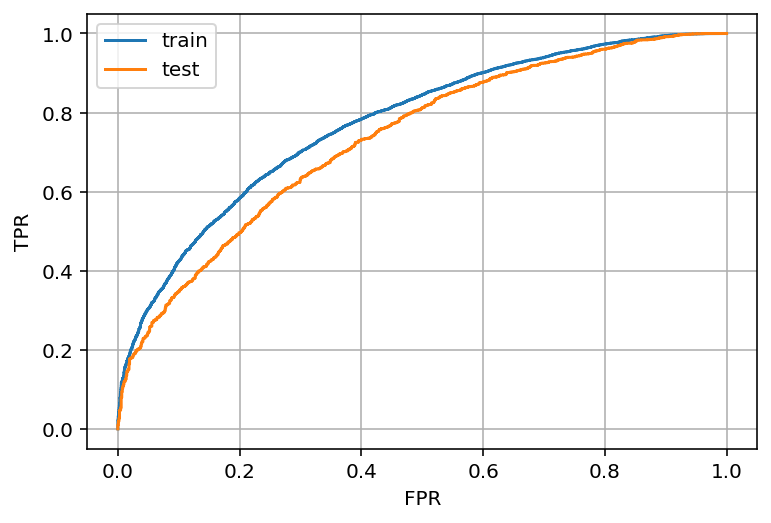

In [63]:
y_pred_xgb_test = clf_xgb.predict_proba(X_test)[:, 1]
y_pred_xgb_train = clf_xgb.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_xgb_train, 'train')
print('Test:')
calc_auc(y_test, y_pred_xgb_test, 'test')
plt.grid()
plt.legend();

### Важность признаков

#### Встроенные методы

Нужно вытащить из sklearn обертки оригинальный объект класса xgboost.core.Booster

Есть 3 типа важности в get_score():

    weight - суммарное кол-во раз, когда признак использовался для разбиения вершины
    gain - средний прирост качества, когда признак использовался для разбиения вершины
    cover - среднее кол-во объектов, которые попадали в разбиение по признаку, когда он использовался для разбиения вершины

Wall time: 76 ms


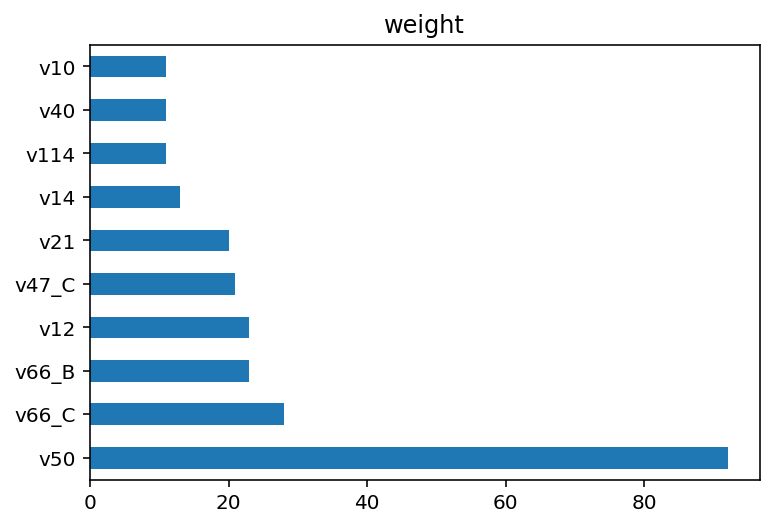

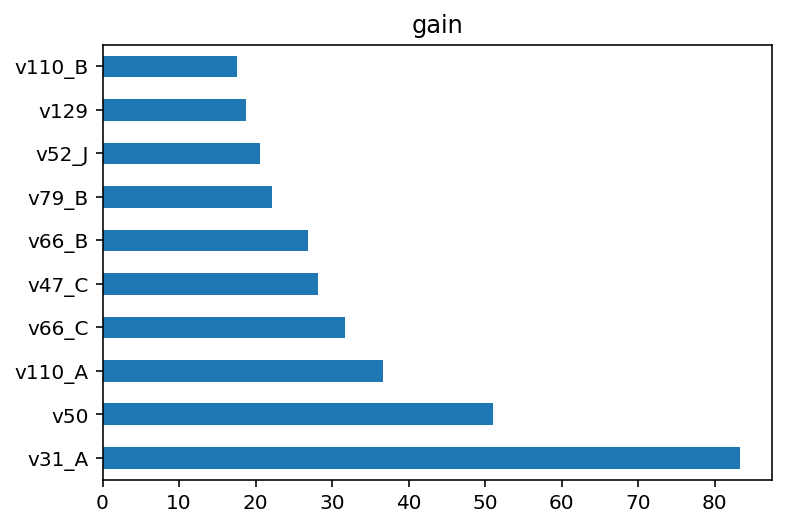

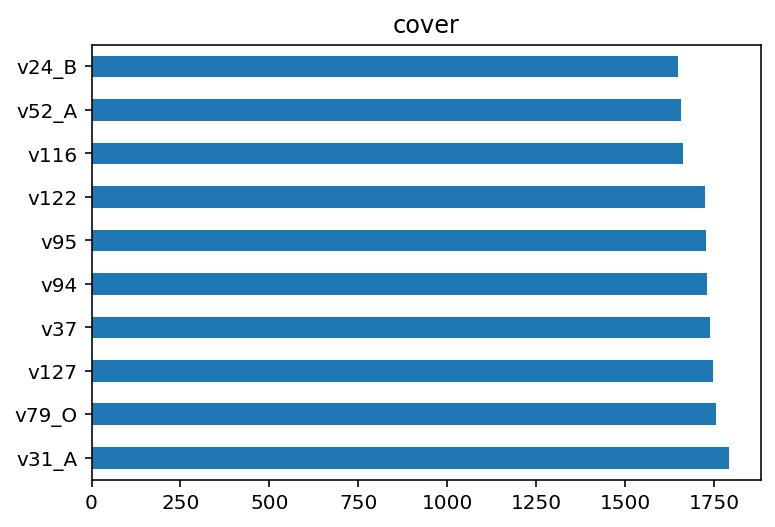

In [64]:
%%time

bst = clf_xgb.get_booster()

for kind in ['weight', 'gain', 'cover']:
    imp = pd.Series(bst.get_score(importance_type=kind))
    plt.figure()
    imp.sort_values(ascending=False).iloc[:10].plot(kind='barh', title=kind)

#### XGBFI

Позволяет оценивать важности взаимодействия признаков

https://github.com/limexp/xgbfir

In [65]:
import xgbfir
xgbfir.saveXgbFI(clf_xgb, OutputXlsxFile='xgbfi_report.xlsx')

In [108]:
pd.read_excel('xgbfi_report.xlsx', sheet_name=0)

,Interaction,Gain,FScore,wFScore,Average wFScore,Average Gain,Expected Gain,Gain Rank,FScore Rank,wFScore Rank,Avg wFScore Rank,Avg Gain Rank,Expected Gain Rank,Average Rank,Average Tree Index,Average Tree Depth
0,v50,39001.806344,453,154.414074,0.340870,86.096703,31258.378522,1,1,1,5,2,1,1.833333,47.481236,2.256071
1,v66_C,7256.582910,141,39.280479,0.278585,51.465127,2353.812232,2,2,2,10,4,3,3.833333,47.283688,2.333333
2,v31_A,5750.995392,56,31.637521,0.564956,102.696346,5206.516689,3,13,4,1,1,2,4.000000,50.000000,1.357143
3,v110_A,4592.045340,67,22.516947,0.336074,68.537990,1856.131687,4,10,5,6,3,4,5.333333,46.791045,1.850746
4,v47_C,4133.375005,108,34.568697,0.320081,38.271991,1685.112194,5,6,3,8,7,5,5.666667,45.759259,2.287037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,v79_K,16.422373,3,0.111355,0.037118,5.474124,0.587081,96,93,96,94,69,98,91.000000,31.333333,3.666667
96,v43,16.183966,5,0.118902,0.023780,3.236793,0.453083,97,73,95,99,98,99,93.500000,40.600000,3.800000
97,v69,15.804565,4,0.449483,0.112371,3.951141,1.097405,98,81,63,32,92,89,75.833333,51.000000,4.000000
98,v79_O,15.430054,3,0.402239,0.134080,5.143351,2.373266,99,94,67,23,75,68,71.000000,59.666667,3.666667


## CatBoost

In [53]:
from catboost import CatBoostClassifier, Pool

In [64]:
train_data = X_train
train_labels = y_train
eval_data = X_test
eval_labels = y_test
eval_dataset = Pool(eval_data,
                    eval_labels)





clf_catb = CatBoostClassifier(
                   
                           iterations=2000,
                           learning_rate=0.01,
                           eval_metric='AUC',
                            max_depth=7,
                           loss_function='CrossEntropy',
                           use_best_model=True,
                           custom_metric=['Accuracy','F1',
                                          'AUC:hints=skip_train~false'],
                                                     )

In [65]:
clf_catb.fit(train_data,
          train_labels,
          eval_set=eval_dataset,
          verbose=False,
          plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [66]:
clf_catb.best_score_

{'learn': {'Accuracy': 0.8371965886726438,
  'F1': 0.9021553423577342,
  'CrossEntropy': 0.3768736186361877,
  'AUC': 0.8897226821584047},
 'validation': {'Accuracy': 0.7830745681172097,
  'F1': 0.8727735368956743,
  'CrossEntropy': 0.475437603064545,
  'AUC': 0.7406083574569642}}

Train:
ROC AUC: 0.8736
Test:
ROC AUC: 0.7406


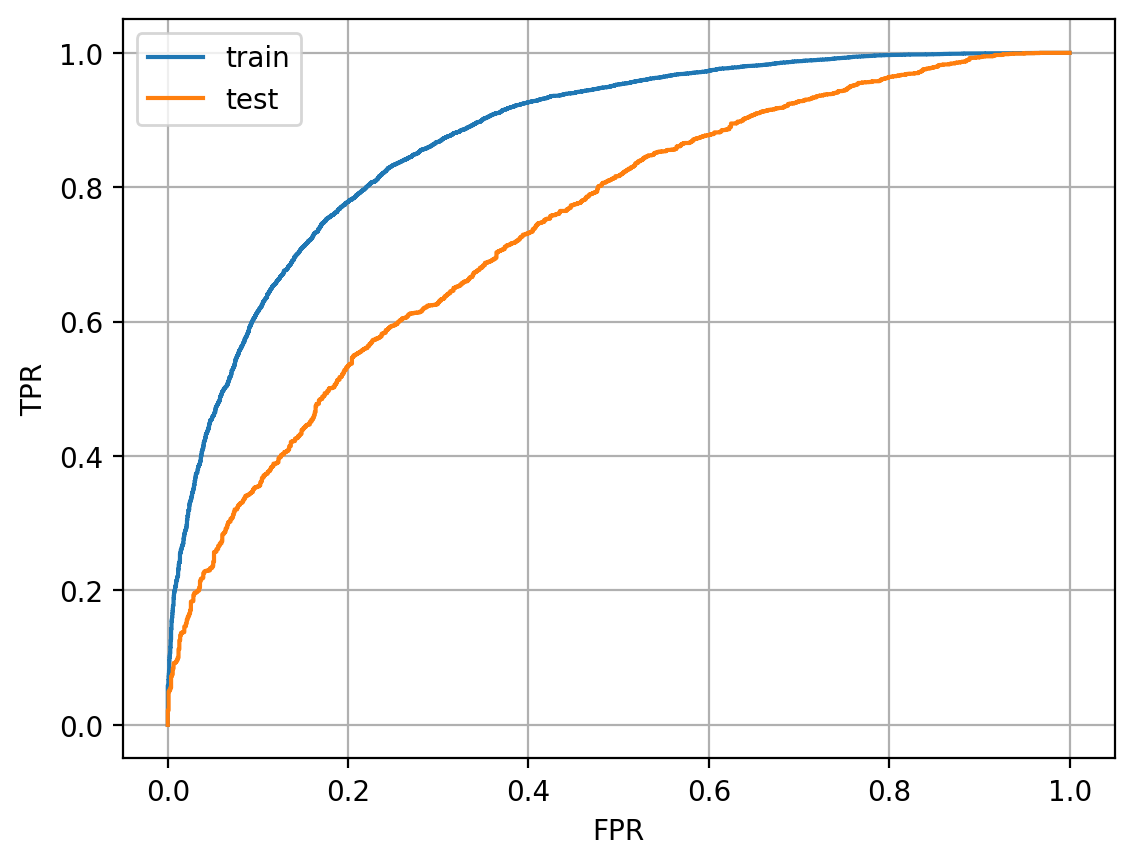

In [67]:
y_pred_catb_test = clf_catb.predict_proba(X_test)[:, 1]
y_pred_catb_train = clf_catb.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_catb_train, 'train')
print('Test:')
calc_auc(y_test, y_pred_catb_test, 'test')
plt.grid()
plt.legend();

In [68]:
from catboost import Pool, cv
train_data = X_train
train_labels = y_train
eval_data = X_test
eval_labels = y_test
eval_dataset = Pool(eval_data,
                    eval_labels)
                    

In [72]:
params = {"iterations": 3000,
          "learning_rate": 0.01,
          "eval_metric": "AUC",
          "max_depth": 7,
          "loss_function":"CrossEntropy",
          "use_best_model":True,
          "custom_metric":['Accuracy','F1',
                                          'AUC:hints=skip_train~false']}

In [73]:
scores = cv(eval_dataset,
            params,
            fold_count=5, 
            plot="True")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]
0:	learn: 0.7018239	test: 0.6751294	best: 0.6751294 (0)	total: 38.5ms	remaining: 38.5s
1:	learn: 0.7150634	test: 0.6827343	best: 0.6827343 (1)	total: 72.5ms	remaining: 36.2s
2:	learn: 0.7302543	test: 0.6859895	best: 0.6859895 (2)	total: 111ms	remaining: 36.9s
3:	learn: 0.7324956	test: 0.6876434	best: 0.6876434 (3)	total: 150ms	remaining: 37.3s
4:	learn: 0.7453927	test: 0.6927867	best: 0.6927867 (4)	total: 189ms	remaining: 37.6s
5:	learn: 0.7471479	test: 0.6955909	best: 0.6955909 (5)	total: 221ms	remaining: 36.6s
6:	learn: 0.7442475	test: 0.6962448	best: 0.6962448 (6)	total: 252ms	remaining: 35.7s
7:	learn: 0.7446536	test: 0.6935734	best: 0.6962448 (6)	total: 285ms	remaining: 35.4s
8:	learn: 0.7473951	test: 0.6942867	best: 0.6962448 (6)	total: 312ms	remaining: 34.4s
9:	learn: 0.7471554	test: 0.6965769	best: 0.6965769 (9)	total: 339ms	remaining: 33.6s
10:	learn: 0.7477248	test: 0.7017937	best: 0.7017937 (10)	total: 368ms	remaining: 33.1s
11:	learn: 0.7503812	test: 